Notebook adaptado del curso “Diplomatura en Inteligencia Artificial y Ciencia de Datos” dictado por la ECyT-UNSAM en el marco del plan Argentina Programa 4.0

# Redes Neuronales Artificiales



In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Nuestra estrella aquí es el TensorFlow
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model, Input


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.19.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Vamos a explorar algunos usos básicos del paquete `keras` para construir y entrenar RNAs.

Hay diferentes formas en las que `keras` puede construir modelos de RNA. En particular, veremos las APIs Secuencial y Funcional. Para las redes feed-forward totalmente conectadas, la API Secuencial es probablemente la más directa.

## Redes neuronales como aproximadores

Construiremos un modelo para realizar la sencilla tarea de aproximar una función real 1-D.

### API secuencial y API funcional

Keras ofrece dos estilos principales de API para construir modelos de aprendizaje profundo: la API Funcional y la API Secuencial. Ambas son útiles dependiendo de las necesidades del modelo y su complejidad.

#### API secuencial

La API Secuencial es la forma más simple de construir un modelo en Keras, las capas se apilan una tras otra  formando un flujo directo de entrada a salida. Por ejemplo:

In [3]:
# Instancia modelo
model_secu = keras.models.Sequential()

# Usa el método add para añadir una capa de entrada (que también es una clase de keras)
# En este caso la entrada es un único valor, pero siempre recibe una tupla
model_secu.add(keras.layers.InputLayer(input_shape=(1,)))

# Añade dos capas ocultas totalmente conectadas (también llamadas densas)
# Se puede cambiar la función de activación
model_secu.add(keras.layers.Dense(5, activation='tanh'))
model_secu.add(keras.layers.Dense(4, activation='tanh'))

# Añade la capa de salida. Como se trata de un problema de regresión, elegimos la activación lineal
model_secu.add(keras.layers.Dense(1, activation='linear'))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


#### API funcional

La API Funcional es más flexible y se utiliza para construir modelos complejos, como:

- Modelos con múltiples entradas o salidas.
- Redes con bifurcaciones.
- Redes con capas compartidas.

El modelo se define como un grafo de capas, en lugar de una simple secuencia. Esto permite personalizar completamente el flujo de datos entre las capas, por ejemplo:

In [4]:
# Definir la capa de entrada
inputs = Input(shape=(1,))  # Capa de entrada con un único valor como entrada

# Primera capa oculta
x = layers.Dense(5, activation='tanh')(inputs)

# Bifurcación
branch_1 = layers.Dense(4, activation='relu')(x)  # Rama 1
branch_2 = layers.Dense(4, activation='tanh')(x)  # Rama 2

# Concatenación
merged = layers.Concatenate()([branch_1, branch_2])

final_hidden = layers.Dense(3, activation='relu')(merged)

# Capa de salida
outputs = layers.Dense(1, activation='linear')(final_hidden)

# Crear el modelo
model_func = Model(inputs=inputs, outputs=outputs)

### Instanciando el modelo
Una vez que creamos el modelo (con cualquiera de las API) podemos ver algunas detalles usando el método `summary`.

In [5]:
# El None en el "Output Shape" representa el tamaño del lote, a esta altura todavia no está definido en el modelo
model_secu.summary()
#model_func.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 5)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39 (156.00 B)

 Trainable params: 39 (156.00 B)

 Non-trainable params: 0 (0.00 B)

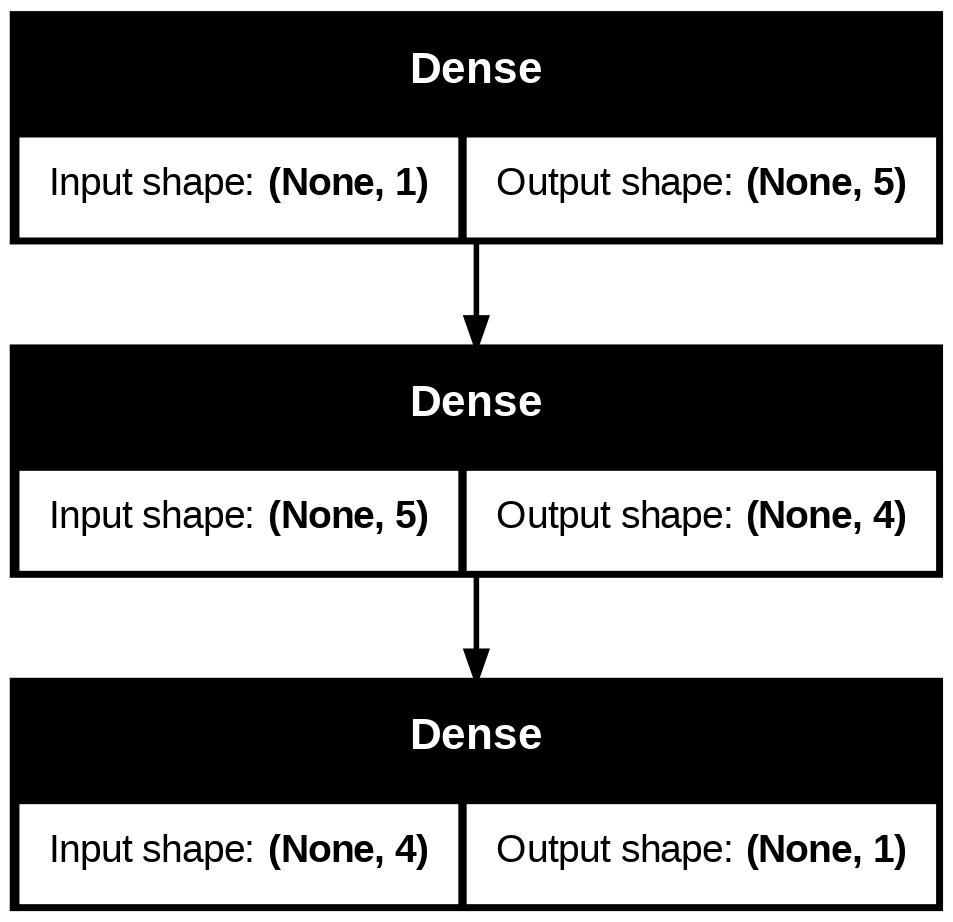

In [6]:
keras.utils.plot_model(model_secu, show_shapes=True)
#keras.utils.plot_model(model_func, show_shapes=True)

### Compilación

Una vez que el modelo es instanciado y definido, necesitamos "Compilarlo" antes de poder utilizarlo. En el paso de compilación, Keras creará el gráfico computacional del modelo en TensorFlow. En este paso, definimos todas las demás piezas importantes de nuestro modelo:

* La **función de pérdida**, que la retropropagación tratará de minimizar (por ejemplo, MSE)
* El **optimizador** que utilizaremos para minimizar la pérdida (por ejemplo, SGD)
* Las **métricas** que querremos seguir a lo largo del entrenamiento

In [7]:
model_secu.compile(loss='mean_squared_error',
               optimizer=keras.optimizers.SGD(learning_rate=0.1),
               metrics=["mse"])

### Preparación de los datos

Pongamos a prueba nuestro modelo con una función sencilla.

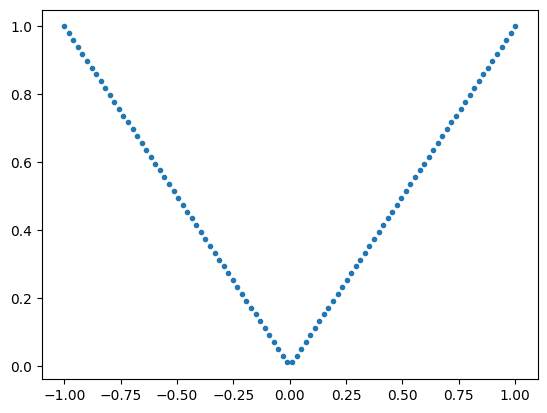

In [8]:
x = np.linspace(-1, 1, 100)

# Modulo
t = np.abs(x)

# Heavyside
# t = np.where(x > 0, 1, 0)

plt.plot(x, t, '.')
plt.show()

### Entrenamiento

Ahora estamos listos para ajustar el modelo.

En su forma más simple, el método `fit` toma el vector de entrada `x` (aquí 1-d) y la etiqueta `t` (aquí 1-d). También necesita un número de `epochs` o pasos a realizar en la dirección del gradiente.

**N.B.** De hecho, este es el número de veces que se evalúa el gradiente utilizando todos los puntos de datos, pero el Descenso Gradiente Estocástico realmente actualiza el vector de parámetros para cada lote (*batch*) de datos. Su tamaño también se puede proporcionar como un argumento para el método `fit`.

In [9]:
model_secu.fit(x, t, batch_size=int(len(x)/4), epochs=250)

Epoch 1/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2648 - mse: 0.2648 
Epoch 2/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0963 - mse: 0.0963
Epoch 3/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1061 - mse: 0.1061 
Epoch 4/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1007 - mse: 0.1007
Epoch 5/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0926 - mse: 0.0926
Epoch 6/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0818 - mse: 0.0818
Epoch 7/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0828 - mse: 0.0828
Epoch 8/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0726 - mse: 0.0726
Epoch 9/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0745 - mse: 0.0745
Epoch 10/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0662 - mse: 0.0662
Epoch 11/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0663 - mse: 0.0663 
Epoch 12/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0600 - mse: 0.0600 
Epoch 13/250
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms

### Predicción

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


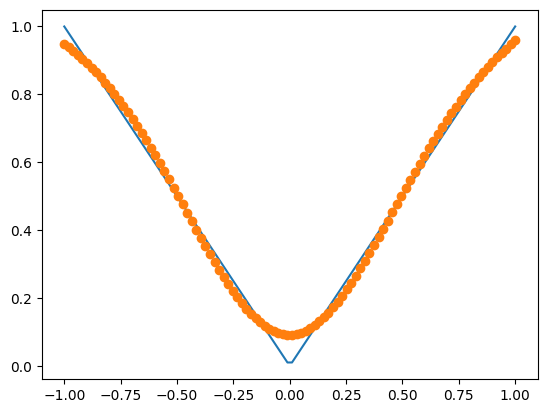

In [10]:
y = model_secu.predict(x)
plt.plot(x, t)
plt.plot(x, y, 'o')

### Bajo el capot

En esta red simple, podemos ver cómo funcionan las cosas. Obtengamos los pesos de cada capa.

In [11]:
w1, b1 = model_secu.layers[0].get_weights()
w2, b2 = model_secu.layers[1].get_weights()
w3, b3 = model_secu.layers[2].get_weights()

Los pesos son matrices cuyo tamaño está relacionado con el tamaño de la capa y el número de unidades que conecta.
El segundo argumento es un array con los pesos.

In [14]:
print(w2.shape, b2.shape)
print(w2, b2)
#w2 la capa anterior tiene 5 neuronas y esta capa tiene 4 neuronas.
#Cada fila representa las conexiones de una neurona de la capa anterior a las 4 neuronas de la capa actual.

(5, 4) (4,)
[[ 0.47258282  0.40386638  0.42763573 -0.3293811 ]
 [ 0.11653189 -0.6975934   0.5187167   0.7844156 ]
 [-0.13436437 -0.49020365 -0.6244939   0.85646707]
 [-0.61682206 -0.34418267  0.84329623 -0.5555508 ]
 [-0.75249386  0.6241969  -0.22546175  0.05245977]] [-0.42406133  0.10322995 -0.21099491 -0.42166272]


Con toda esta información, podemos calcular el resultado de la segunda capa, para cada punto del conjunto de datos.

In [15]:
def acti(x):
    return np.tanh(x)

In [17]:
zz = []
for i in range(len(w1[0])):
  zz.append(acti(w1[0][i] * x + b1[i]))

    # xx = w1[0][i] * x + w0[i]
  # yy.append(np.where(xx > 0, xx, 0))

zz = np.array(zz).T
print(zz.shape)

(100, 5)


In [18]:
# Calcula salida de la segunda capa
yy = acti(np.dot(zz, w2) + b2)

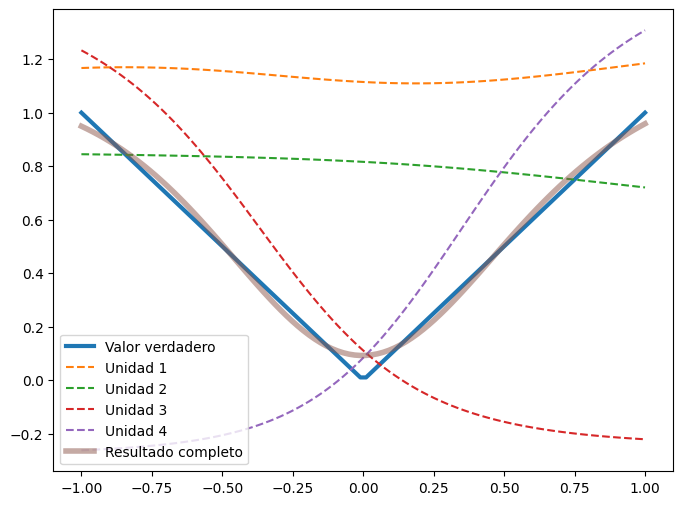

In [19]:
# El resultado final es la combinación de cada una de estas cuatro funciones, con un peso...
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

ax.plot(x, t, lw=3, label='Valor verdadero')
for i, yi in enumerate(yy.T):
  ax.plot(x, yi * w3[i] + b3, '--', label='Unidad {}'.format(i+1))

ax.plot(x, np.dot(yy, w3) + b3, label='Resultado completo', lw=4, alpha=0.5)
ax.legend(loc=0)

## MNIST a través de la lente de las RNAs

Vamos a reutilizar el conjunto de datos MNIST de números escritos a mano y a entrenar una red neuronal sencilla para clasificarlos.

El objetivo es entonces tratar de entender cómo funciona la red, por lo que vamos a elegir una arquitectura relativamente sencilla.

### Preparación de los datos

In [20]:
(X_train, t_train), (X_test, t_test) = keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Se acuerdan de el tamaño deste dataset?

In [ ]:
X_train.shape, X_test.shape, t_train.shape, t_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

Las etiquetas de `t_train` y `t_test` son números entre 0 y 9.

Lo primero que hacemos es convertir las etiquetas de clase a la codificación 1-de-K. Para ello utilizamos la función `keras.utils.to_categorical` (similar al  `OneHotEncoder` de `sklearn`).

In [ ]:
t_train_ohe = keras.utils.to_categorical(t_train)
t_test_ohe = keras.utils.to_categorical(t_test)
print(t_train_ohe[:3], t_train[:3])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]] [5 0 4]


A continuación, normalizamos las imágenes. Llevamos la escala de píxeles, originalmente entre 0 y 255 (o sea, 256 "niveles de gris"), al intervalo [0, 1).

In [ ]:
print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

X_train = X_train/255.0
X_test = X_test/255.0

print(X_train.min(), X_train.max())
print(X_test.min(), X_test.max())

0 255
0 255
0.0 1.0
0.0 1.0


No hay mucho más que hacer en cuanto a la preparación de los datos, porque `keras` ya divide el conjunto en conjuntos de entrenamiento y de prueba (que usaremos como validación).

Visualicemos simplemente a algunos individuos.

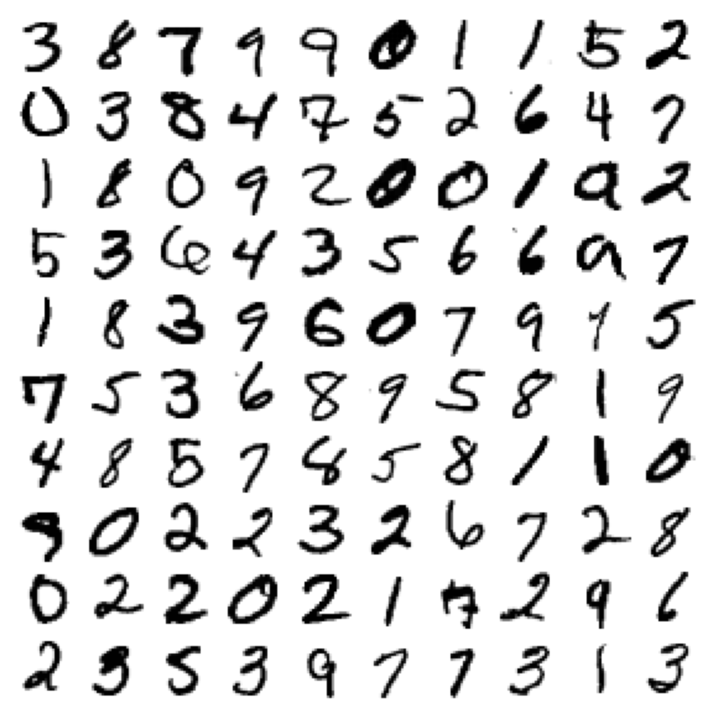

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap ='binary', **options)
    plt.axis("off")

plt.figure(figsize=(9,9))
plot_digits(X_train[10000:10100], images_per_row=10)

### Definición del modelo.

¿Cómo empezamos a definir un modelo de este tipo? Tenemos que definir el número de capas, el número de unidades en cada capa, las funciones de activación, y varias cosas más.

Una posibilidad es pensar como funcionaria el reconocimiento de las imágines, separándolo en etapas y pensando que cada _capa de neuronas_ podría corresponder a una _etapa_ y cada _conjunto de reuronas_ podría hacer _una tarea de cada etapa_. Eso se manifiesta en la respuesta de cada neurona a in tipo de dato de entrada, o sea, a su _activación_ para cada dato.

Para ver después de la clase: un video de YouTube armando una red inspirada en ese tipo de razonamiento.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('aircAruvnKk?start=332', width=900, height=600)

Aqui vamos a implementar una red (completamente conectada) con 2 capas intermediarias, con 32 neruronas cada. El número de neuronas en las capas de entrada y de salida se define, respectivamente por los datos que queremos procesar (en este caso, imágenes de 28 x 28 pixeles) y por la salida de clasificación (1 valor para cada una de las 10 clases). Como es un problema de clasificación, usaremos la activación `softmax`.

In [ ]:
model = keras.models.Sequential()

# Input layer
model.add(keras.layers.Flatten(input_shape=(28,28)))

# Dos capas ocultas con 32 neuronas cada una
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))

# Capa de salida. Como es una clasificación multi-clase, usamos K (acá 10) unidades.
model.add(keras.layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compilación

Como ya mencionamos en las etiquetas para clasifcación usamos la codificación 1-de-K, esto es "one-hot encoded" donde las categorias están codificadas en formato binario. Supongamos que tenemos 3 clases posibles de salida (clase 1, clase 2 y clase 3) una etiqueta de un elemento perteneciente a la primera clase seria un vector (1,0,0), uno de la clase 2 (0,1,0) y (obviamente) uno de la clase 3 (0,0,1). Se hace esto para tratar de evitar relaciones artificiales entre las categorias, si usásemos enteros para codificar las clases (1, 2, 3) un modelo podría interpretar erróneamente que 3 es más parecido a 2 que a 1, lo cual no tiene sentido en datos categóricos. El one-hot encoding elimina esta jerarquía artificial. La función de pérdida correcta para este tipo de datos es la `categorical_crossentropy`.

Si, en cambio, usamos dígitos como etiquetas la función adecuada es `sparse_categorical_crossentropy` (internamente convierte las etiquetas enteras en una representación one-hot de forma automática y luego calcula la pérdida de manera similar a `categorical_crossentropy`).


También le decimos al modelo que reporte la Precisión (accuracy), pero podríamos proporcionar otras métricas aquí: `keras.metrics.Recall()`

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(class_id=5)])

***
**Juego**: ¿Pueden calcular el número de parámetros que tiene este modelo?

In [ ]:
((28*28)+1)*32 + 33*32 + 33*10

26506

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 10)                  │             330 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

El entrenamiento puede ser complicado y/o costoso, incluso para una red pequeña como ésta.

Para acelerar el proceso, y comprobar que la red no está sobreajustada, añadiremos un paso adicional en el proceso de ajuste. Un _callback_ que puede detener el entrenamiento antes de tiempo si no se ve ninguna mejora en la pérdida de validación.

Esto se implementa en `EarlyStopping`. Volveremos sobre esto la semana que viene.

In [ ]:
early = keras.callbacks.EarlyStopping(patience=15, monitor='val_loss',
                                      restore_best_weights=True)

En este caso, esperamos 15 épocas para ver una mejora. Si no se ve ninguna, el ajuste vuelve a los valores óptimos y se detiene el entrenamiento. Esto es _muy_ útil.

Sabemos que se ajusta al modelo, pero fíjate en los siguientes cambios:

1. La salida del método se almacena en una variable `ajuste` que contiene la evolución del proceso de traning.
2. Añadimos el argumento `validation_data` para definir qué conjunto de datos utilizar para la validación.
3. Incluimos un callback (podría haber una legión; ver `keras.callbacks` y [documentación](https://keras.io/api/callbacks/).

In [ ]:
ajuste = model.fit(epochs=100, x=X_train, y=t_train_ohe, validation_data=(X_test, t_test_ohe),
                    callbacks=[early,])

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9603 - loss: 0.1376 - recall: 0.9390 - val_accuracy: 0.9580 - val_loss: 0.1452 - val_recall: 0.9439
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9651 - loss: 0.1173 - recall: 0.9530 - val_accuracy: 0.9596 - val_loss: 0.1420 - val_recall: 0.9025
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9697 - loss: 0.1050 - recall: 0.9512 - val_accuracy: 0.9614 - val_loss: 0.1326 - val_recall: 0.9496
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9721 - loss: 0.0970 - recall: 0.9526 - val_accuracy: 0.9667 - val_loss: 0.1192 - val_recall: 0.9608
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9733 - loss: 0.0913 - recall: 0.9619 - val_accuracy: 0.9655 - val_loss: 0.1233 - val_recall: 0.9731
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9761 - loss: 0.0837 - recall: 0.9622 - val_accuracy: 0.9666 - val_loss: 0.1258 - val_r

Nos gustaría ver un gráfico de la evolución del ajuste. De esto se trata la variable `ajuste`.

In [ ]:
ajuste.history

{'accuracy': [0.9596666693687439,
  0.9644166827201843,
  0.9687833189964294,
  0.9712833166122437,
  0.9730333089828491,
  0.9750833511352539,
  0.9762499928474426,
  0.9773833155632019,
  0.9789166450500488,
  0.9808666706085205,
  0.9806333184242249,
  0.9812999963760376,
  0.9825999736785889,
  0.9830499887466431,
  0.9834833145141602,
  0.9842166900634766,
  0.9846833348274231,
  0.9851999878883362,
  0.9855999946594238],
 'loss': [0.13786214590072632,
  0.12042579054832458,
  0.1094583198428154,
  0.09953105449676514,
  0.09146285802125931,
  0.0860309898853302,
  0.08084946125745773,
  0.07626268267631531,
  0.07216677069664001,
  0.06880532205104828,
  0.06644562631845474,
  0.06379744410514832,
  0.06015672907233238,
  0.058575402945280075,
  0.05774587020277977,
  0.05468021705746651,
  0.05231287330389023,
  0.05200866609811783,
  0.05056500807404518],
 'recall': [0.9383877515792847,
  0.9472422003746033,
  0.9570189714431763,
  0.95867919921875,
  0.9610772728919983,
  0.96

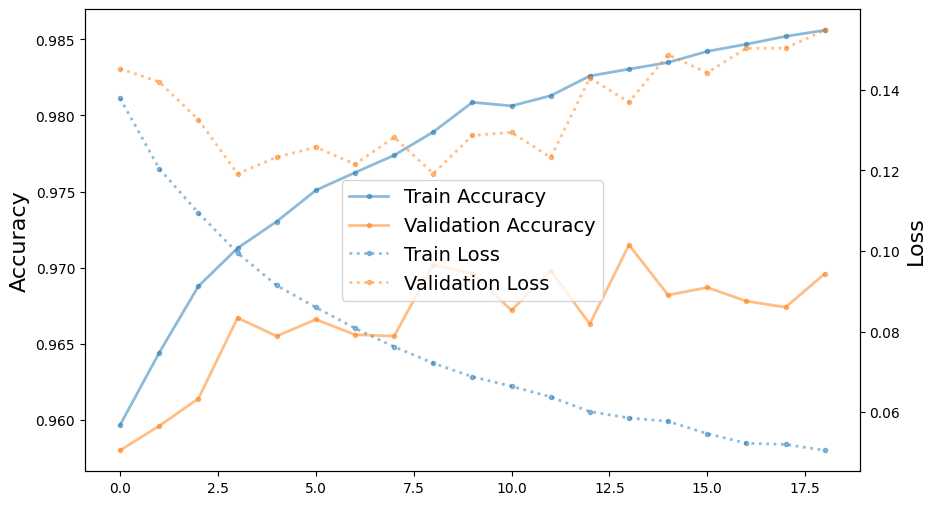

In [ ]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

kw = {'marker': '.', 'lw': 2, 'alpha': 0.5}
l0, = ax.plot(ajuste.history['accuracy'], label='Train Accuracy', **kw)
l1, = ax.plot(ajuste.history['val_accuracy'], label='Validation Accuracy', **kw)

ax2 = ax.twinx()
ll0, = ax2.plot(ajuste.history['loss'], ls=':', color='C0', label='Train Loss', **kw)
ll1, = ax2.plot(ajuste.history['val_loss'], ls=':', color='C1', label='Validation Loss', **kw)

ax.set_ylabel('Accuracy', fontsize=16)
ax2.set_ylabel('Loss', fontsize=16)

ax.legend(handles=[l0, l1, ll0, ll1], loc='center', fontsize=14)
# plt.legend(loc=0)

# Otra formas más estandar para plotear

#pd.DataFrame(ajuste.history).plot(figsize=(8, 5))
#plt.grid(True)
#plt.gca().set_ylim(0, 1)
#plt.show()


## Persistencia: Guardar y cargar modelos

Para guardar nuestros modelos ajustados necesitamos guardar tanto la estructura de la red como los pesos. Esto es más eficiente que guardar toda la clase. Keras proporciona métodos transparentes para guardar y cargar modelos utilizando un formato H5.

In [ ]:
model.save("my_keras_model.h5")
# o se puede salvar en un formato específico de keras
model.save('my_model.keras')

Y para cargar...

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

Una opción más liviana es sólo guardar los pesos de cada capa:

In [ ]:
model.save_weights("my_keras.weights.h5")

Y antes de cargar los pesos, tendremos que definir la arquitectura del modelo, y tiene que ser idéntica a la que utilizamos para guardarla. Sólo entonces, podemos cargar diferentes pesos.

In [ ]:
model.load_weights("my_keras.weights.h5")

## Otras técnicas de regularización

### Reducción de pesos / _Weight Decay_

Sabemos que podemos flexibilizar nuestra red añadiendo más neuronas o capas. Pero, ¿cómo podemos regularizarla para evitar el sobreajuste? A continuación, hablaremos de algunas técnicas comunes.

La idea por detrás de la reducción de pesos es la misma que la de los métodos de regularización Ridge y Lasso para modelos lineales: Cuanto más pequeños sean los pesos, menores serán los *grados de libertad efectivos* de nuestro modelo. Además, al evitar que los pesos sean grandes, obligamos a nuestra red a no ser demasiado dependiente de una característica determinada, y por tanto de su ruido.

Podemos especificar el método de regularización en la instatiación de la capa, utilizando el método `kernel_regularizer`. Podemos entonces utilizar un Ridge (`keras.regularizers.l2()`), Lasso (`keras.regularizers.l1()`) o una red elástica (`keras.regularizers.l1_l2()`).

In [ ]:
#Por ejemplo, para definir una capa densa con una función de activación ReLU, 100 neuronas y una regularización l2 (~Ridge) con un factor alfa de 0,01:
layer = keras.layers.Dense(100,
                          activation='relu',
                          kernel_regularizer=keras.regularizers.l2(0.01))

Para ahorrar en la escritura, podemos definir nuestras capas regularizadas utilizando la herramienta `parcial`:

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation='relu',
                          kernel_regularizer=keras.regularizers.l2(0.01))

model_part = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])

### _Dropout Layer_

Una forma popular de regularizar las redes neuronales profundas se propuso en dos artículos de 2012 y 2014: En cada paso de entrenamiento, algunas de las neuronas tienen una probabilidad $p$ de "apagarse" (sus salidas se ponen a cero). Esto se hace sólo durante el entrenamiento, y para la predicción todas las neuronas están encendidas (y sus pesos debidamente reponderados para tener en cuenta el aumento de $1/p$ en la señal).

La idea principal detrás de esto es forzar a la red a no depender demasiado de una neurona en particular, forzándola a entregar *buenos* resultados incluso cuando esa neurona está apagada. Existen también algunas variantes de este modelo, como `Alpha-Dropout` y `MCDropout`.

En Keras, este tipo de regularización se ha implementado como una capa, por lo que sólo tenemos que importarla e instanciarla. La probabilidad de desactivación $p$ se establece a través del parámetro `rate`, y la Capa se encarga de retropropagar adecuadamente la señal así como de ajustar los pesos para la evaluación y predicción.

In [ ]:
#Por ejemplo en el modelo para MNIST agregamos dropout después de cada capa:
model_drop = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2), #equivale a apagar algunos pixeles de la imagen
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])

## Análisis

Exploremos ahora un poco más los errores de la red. Para eso, trabajaremos con el conjunto de test (esto no es del todo correcto porque usamos el mismo conjunto para hacer la validación).

In [ ]:
model.evaluate(X_test, t_test_ohe)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9609 - loss: 0.1386 - recall: 0.9572


[0.11918996274471283, 0.96670001745224, 0.9607623219490051]

Veamos con más detalle los casos en los que la red cometió errores

In [ ]:
model.predict(X_test).shape

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


(10000, 10)

In [ ]:
# Calcular las predicciones y encontrar los casos con error
y_test = np.argmax(model.predict(X_test), axis=1)

ierror = (y_test - t_test != 0)

# Cuántos hay
print('Hay {} errores en el conjunto de validación'.format(np.sum(ierror)))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Hay 333 errores en el conjunto de validación


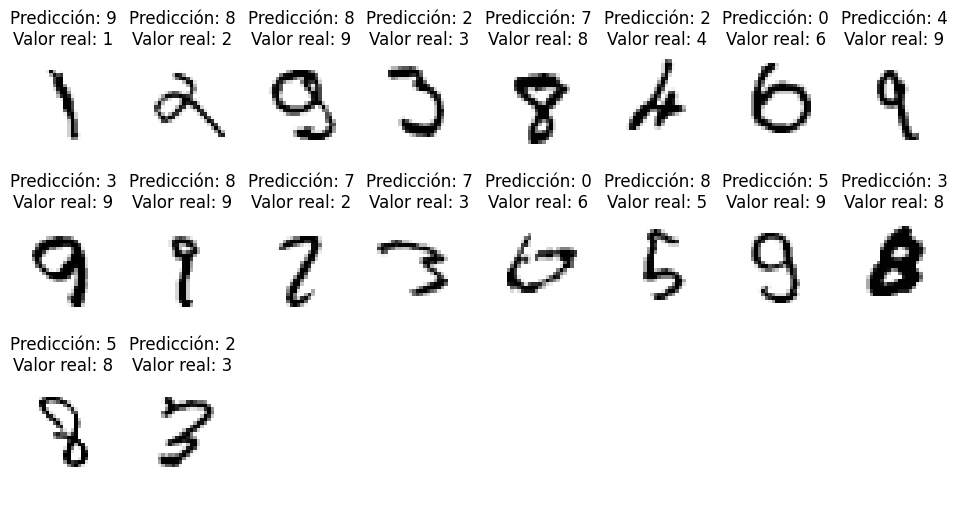

In [ ]:
n_images = 18
n_columns = 8

n_rows = int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))

# Veamos algunos ejemplos de los datos en los que se equivocó
for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ierror][i], interpolation='None', cmap='binary')
    ax.set_title('Predicción: {}\nValor real: {}'.format(y_test[ierror][i], t_test[ierror][i]))

for ax in axs.flatten():
    ax.axis('off')

Bien, esto parece razonable, ¿verdad? Miren esos números. Algunos son realmente difíciles....

Veamos la distribución de probabilidades. Usa la probabilidad de la clase que fue elegida por la red, tanto en el caso de los errores como de los que no lo fueron.

In [ ]:
pred_proba_all = np.max(model.predict(X_test), axis=1)

pred_proba = np.max(model.predict(X_test[~ierror]), axis=1)
pred_proba_err = np.max(model.predict(X_test[ierror]), axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


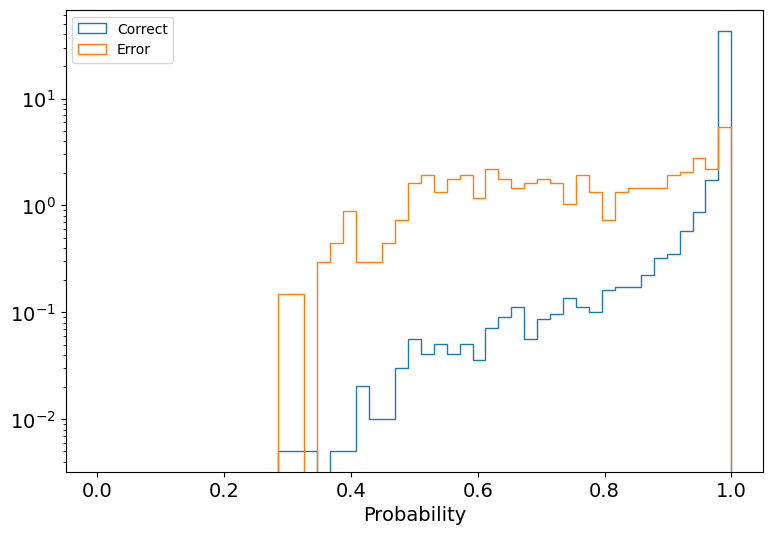

In [ ]:
# Veamos la distribución
fig = plt.figure(figsize=(9,6))

bins = np.linspace(0, 1, 50)
plt.hist(pred_proba, bins=bins, histtype='step', label='Correct', density=True, log=True)
plt.hist(pred_proba_err, bins=bins, histtype='step', label='Error', density=True)

# Labels and ticks
plt.xlabel('Probability', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)

Esto es bueno. La red parece estar menos segura cuando comete errores. Esto significa que podríamos ajustar un poco el umbral de decisión para mejorar el rendimiento.

Pero parece estar bastante segura de algunos casos en los que se equivoca. Vamos a verlos.

In [ ]:
ii = (pred_proba_all > 0.95) * (y_test - t_test != 0)

print('Hay {} imágenes erróneamente clasificadas y con prbabilidad por encima del 95%'.format(sum(ii)))

Hay 63 imágenes erróneamente clasificadas y con prbabilidad por encima del 95%


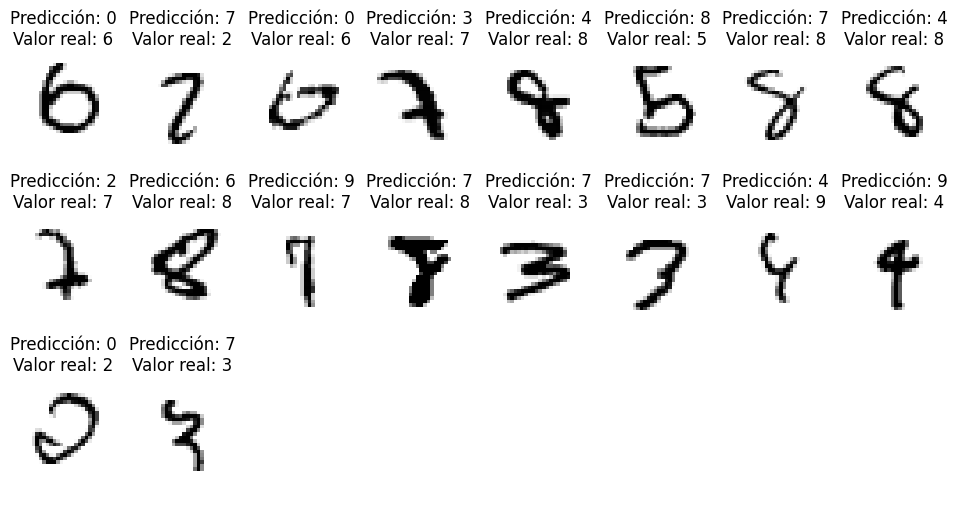

In [ ]:
n_images = 18
n_columns = 8

n_rows = int(n_images / n_columns)

if n_images % n_columns != 0:
    n_rows += 1

fig, axs = plt.subplots(ncols=n_columns, nrows=n_rows, figsize=(12, 2*n_rows))
# Veamos algunos ejemplos de los datos en los que se equivocó

for i, ax in zip(range(n_images), axs.flatten()):
    ax.imshow(X_test[ii][i], interpolation='None', cmap='binary')
    ax.set_title('Predicción: {}\nValor real: {}'.format(y_test[ii][i],
                                                    t_test[ii][i]))

for ax in axs.flatten():
    ax.axis('off')

#### Cómo aprende la red.

Intentemos mirar dentro de la red para entender si entendió algo sobre cómo son los números o no. Hay muchos parámetros, pero tenemos la esperanza de que al menos la primera capa sea algo razonable, como un detector de bordes. Veamos.

Leamos los pesos y el sesgo de la primera capa oculta y veamos las formas.

In [ ]:
# Tengan en cuenta que aquí la capa relevante es la capa[1], ya que la capa[0] es una capa de aplanamiento.
W, b = model.layers[1].get_weights()
print(W.shape, b.shape)

(784, 32) (32,)


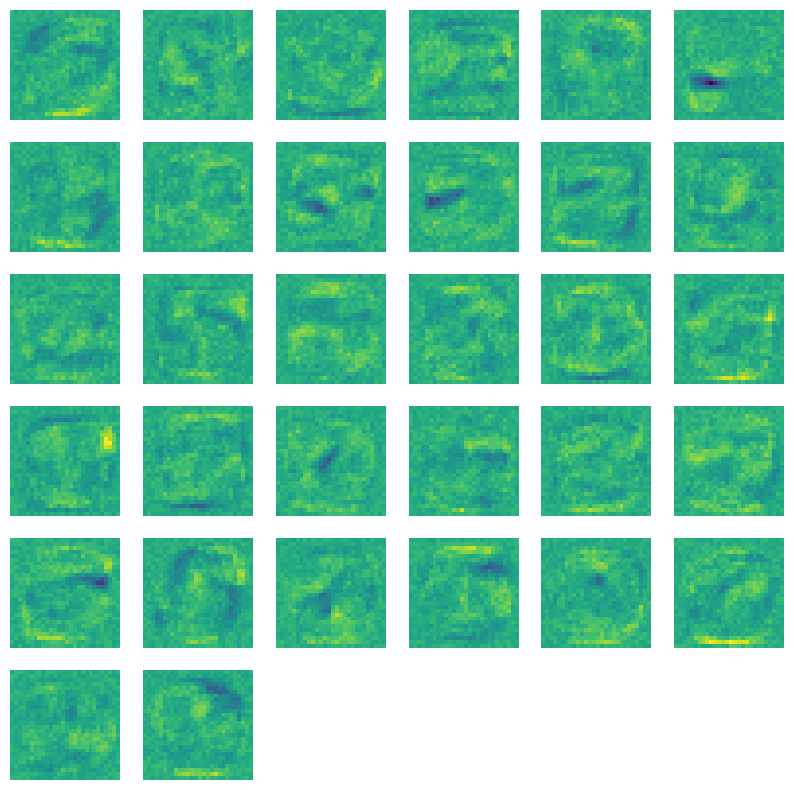

In [ ]:
WW = W.reshape([28,28,32])

# Encontrar límites relevantes para los valores de los píxeles
Wmin = WW[3:-3, 3:-3].min()
Wmax = WW[3:-3, 3:-3].max()

fig = plt.figure(figsize=(10,10))
for i in range(WW.shape[-1]):
    ax = fig.add_subplot(6, 6, i+1)
    #  ax.imshow(WW[2:-2, 2:-2, i], interpolation='None')
    # Fixed limits in Z axis

    ax.imshow(WW[:, :, i], interpolation='None', vmin=Wmin, vmax=Wmax)
    ax.axis('off')

Los pesos de la primera capa no parecen en absoluto detectores de fronteras, ni nada parecido.

Parece que la red encuentra una forma mucho más extraña de generalizar de lo que haríamos nosotros. Veremos que las CNN hacen algo mucho más cercano a lo que uno esperaría.

**¿Tiene esto sentido?**

* Nunca proporcionamos una idea de la vecindad entre las características. ¿Cómo podría saberlo la red?
* ¿Cómo podemos generar una red neuronal que reconozca las imágenes de forma más parecida a como lo hacen los humanos?